In [1]:
import lightgbm
import xgboost
import shap
# print the JS visualization code to the notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
import itertools

import catboost as catb
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

###  1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [3]:
df = pd.read_csv('../lesson_06/data/in-vehicle-coupon-recommendation.csv')

http://archive.ics.uci.edu/ml/datasets/in-vehicle+coupon+recommendation

### 2. сделать обзорный анализ выбранного датасета

In [4]:
df.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [6]:
train_ = len(df) - df.count()
train_.sort_values(ascending=False).head(5)

car                     12576
CoffeeHouse               217
Restaurant20To50          189
CarryAway                 151
RestaurantLessThan20      130
dtype: int64

In [7]:
features_list = ('CoffeeHouse', 'Restaurant20To50', 'CarryAway', 'RestaurantLessThan20', 'Bar')

In [8]:
df = df.rename(columns={df.columns[-1]: "target"})
df['target'].value_counts()

1    7210
0    5474
Name: target, dtype: int64

In [9]:
droped_list = ['car', 'occupation']

In [10]:
df = df.drop(droped_list, axis = 1)

In [11]:
def change_nan_to_mode(df, feature_list):
    
    for item in feature_list:
        df[item].fillna(df[item].mode()[0], inplace=True)
    return df.head(4)

In [12]:
change_nan_to_mode(df, features_list)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,target
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,0


In [13]:
df['target'].value_counts()

1    7210
0    5474
Name: target, dtype: int64

### 3. сделать feature engineering

In [14]:
continuous_columns = df.select_dtypes(include=[np.number]).drop('target',1)
print(f"count of numeric_features {continuous_columns.shape[1]}")
continuous_columns = continuous_columns.columns.to_list()
continuous_columns

count of numeric_features 7


['temperature',
 'has_children',
 'toCoupon_GEQ5min',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same',
 'direction_opp']

In [15]:
cat_feature_num = [
    feature for feature in continuous_columns
    if len(df[feature].unique())<20
]
categorical_columns = df.select_dtypes(include=[np.object]).columns.to_list()
categorical_columns = list(categorical_columns + cat_feature_num)
categorical_columns

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


['destination',
 'passanger',
 'weather',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'education',
 'income',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50',
 'temperature',
 'has_children',
 'toCoupon_GEQ5min',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same',
 'direction_opp']

In [16]:
def feature_selector(df):
    continuous_columns = df.select_dtypes(include=[np.number]).drop('target',1)

    continuous_columns = continuous_columns.columns.to_list()
    
    cat_feature_num = [
    feature for feature in continuous_columns
    if len(df[feature].unique())<20
    ]
    categorical_columns = df.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)

    
    dummies_features = pd.get_dummies(df[categorical_columns])
    df = pd.concat([df, dummies_features], axis=1)
    dummies_features = dummies_features.columns.tolist()
    df = df.drop(categorical_columns, axis=1)
    return df

In [17]:
df = feature_selector(df)


`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                    df['target'], test_size=0.3, random_state=0)

### 4. обучить любой классификатор (какой вам нравится)

In [19]:
cb_params = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = catb.train(catb.Pool(X_train, y_train), cb_params)


0:	total: 50ms	remaining: 9.95s
10:	total: 84.5ms	remaining: 1.45s
20:	total: 122ms	remaining: 1.04s
30:	total: 161ms	remaining: 876ms
40:	total: 196ms	remaining: 759ms
50:	total: 233ms	remaining: 681ms
60:	total: 272ms	remaining: 621ms
70:	total: 312ms	remaining: 567ms
80:	total: 351ms	remaining: 515ms
90:	total: 390ms	remaining: 467ms
100:	total: 426ms	remaining: 418ms
110:	total: 466ms	remaining: 374ms
120:	total: 506ms	remaining: 330ms
130:	total: 543ms	remaining: 286ms
140:	total: 582ms	remaining: 243ms
150:	total: 620ms	remaining: 201ms
160:	total: 658ms	remaining: 159ms
170:	total: 696ms	remaining: 118ms
180:	total: 735ms	remaining: 77.2ms
190:	total: 772ms	remaining: 36.4ms
199:	total: 811ms	remaining: 0us


### 5.разобраться с SHAP и построить важности признаков для: всего тестового набора данных (summary_plot - дать интерпретацию) для топ 10% (сортировка по убыванию вероятности - таргета)

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


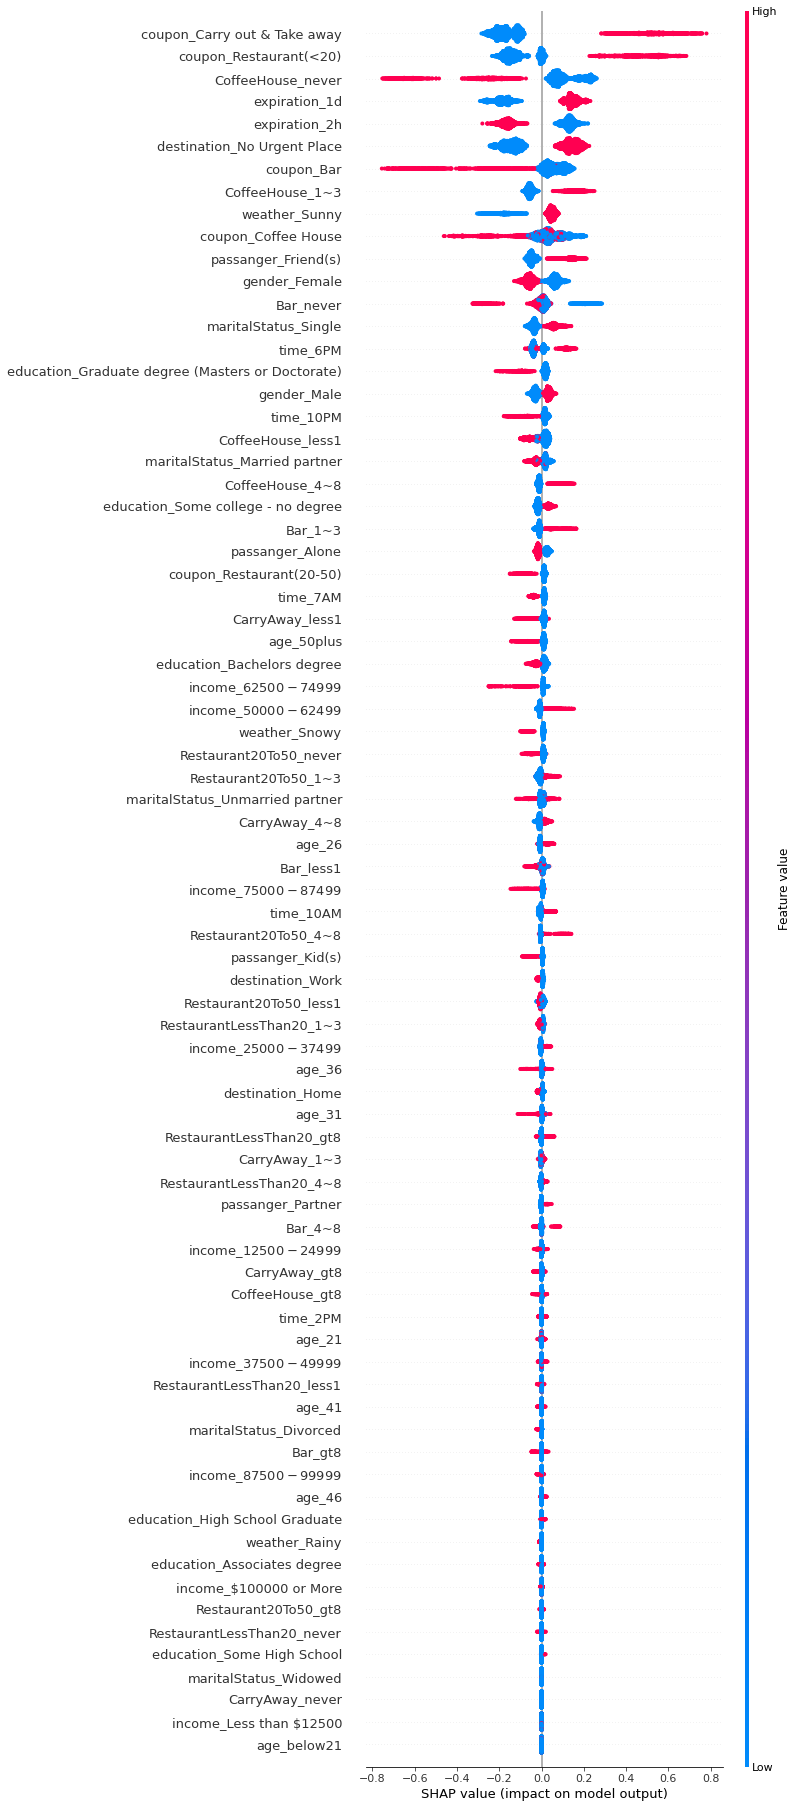

In [29]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=78, auto_size_plot=None)

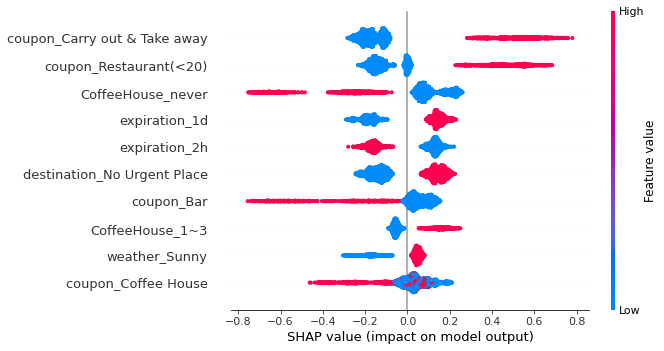

In [30]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=10, auto_size_plot=None)

Вывод : 
* Carry out & Take away чаще берут купоны на скидку и не используют 
* Restaurant(<20) чаще берут купоны на скидку и не используют
* CoffeeHouse_never значение признака указывающее на частоту посещение кофеен, из тех кто не ходит в кофейни много отказов на получение купона 
* expiration_1d срок действия купона . купоны на сутки берут чаще
* expiration_2р эти купоны берут но не используют. вероятнее всего не успевают использовать за два часа
* weather_Synny в солнечную погоду люди охотнее берут купоны на скидку

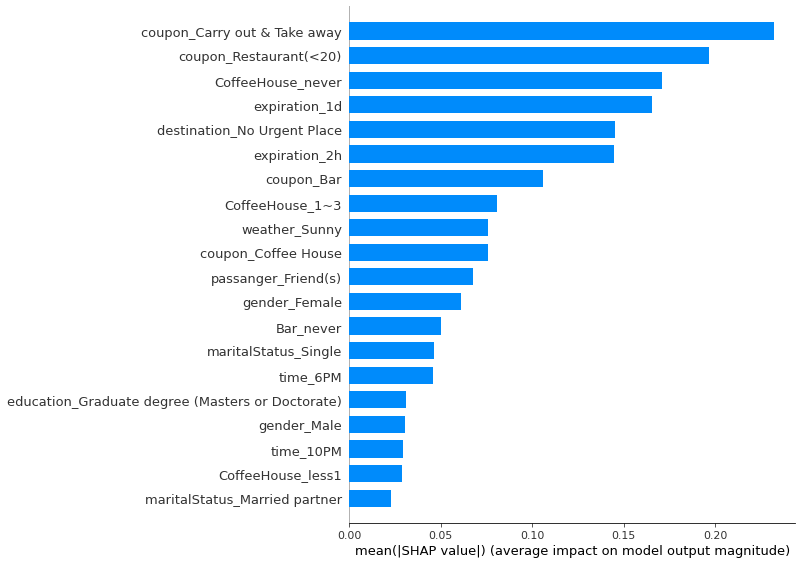

In [31]:
shap.summary_plot(shap_values, X_train, plot_type="bar")